## Valuing passes using Football Tracking Data

Passing is the most frequent event in a football match. This project scratches the surface how we can calculate different parameters of a 'pass' event using tracking data. Traditional metrics to value passes in football mostly utilises the widely available on-the-ball event data.

Tracking data captures much more insights as it includes every player position at each instant. Even though there is very [limited public open source tracking data](https://github.com/metrica-sports/sample-data#other-tracking-data-sources), this project discusses the algorithms for calculating parameters of a pass. As more tracking data would be available, we can compute and analyse how various aspects and scenarios of a pass influence the pass's impact. The pass parameters can itself be features to a trained model.

We also implement the Pitch Control x EPV and the VAEP metric for valuing passes.

All the output files generated has been moved to the output folder

<b>Acknowledgement</b>
- Metrica Sports: For publishing tracking + event data to the community online<br>
  Dataset Link: [Metrica Sports sample tracking and event data](https://github.com/metrica-sports/sample-data)<br><br>
- Laurie Shaw and FriendsOfTracking: For lectures and code to understand and get started with tracking data<br>
  Repo: [Laurie's code for Metrica tracking data](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking)<br>
  Youtube: [Friends of Tracking](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w)

<b>References/Further Reading</b>
- [Valuing passes in football using ball event data](https://thesis.eur.nl/pub/41346/Bransen.pdf)
- Pitch Control: [Lecture](https://www.youtube.com/watch?v=X9PrwPyolyU&t=215s), [Presentation](https://www.researchgate.net/profile/William-Spearman/publication/334849056_Quantifying_Pitch_Control/links/5d434d0aa6fdcc370a742d04/Quantifying-Pitch-Control.pdf)
- EPV: [A Multiresolution Stochastic Process Model for Predicting Basketball Possession Outcomes](https://arxiv.org/pdf/1408.0777.pdf), [A framework for the fine-grained evaluation of the instantaneous expected value of soccer possessions](https://arxiv.org/pdf/2011.09426.pdf)
- VAEP: [Actions Speak Louder than Goals: Valuing Player Actions in Soccer](https://arxiv.org/pdf/1802.07127.pdf)
- [A Framework for Tactical Analysis and Individual Offensive Production Assessment in Soccer Using Markov Chains](http://nessis.org/nessis11/rudd.pdf)

### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import Metrica_EPV as mepv

### 2. Load event data

In [2]:
# set up initial path to data
DATADIR = r"C:\Users\adnanazmat\Downloads\PROJECTS\sample-data\data"
game_id = 2 # let's look at sample match 2

In [3]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# Bit of housekeeping: unit conversion from metric data units to meters
events = mio.to_metric_coordinates(events)

#### 2.1 Get home, away shots and goals

In [4]:
# Get events by team
home_events = events[events['Team']=='Home']
away_events = events[events['Team']=='Away']

# Get all shots
shots = events[events['Type']=='SHOT']
home_shots = home_events[home_events.Type=='SHOT']
away_shots = away_events[away_events.Type=='SHOT']

# Get all passes
shots = events[events['Type']=='PASS']
home_passes = home_events[home_events.Type=='PASS']
away_passes = away_events[away_events.Type=='PASS']

# Get the shots that led to a goal
home_goals = home_shots[home_shots['Subtype'].str.contains('-GOAL')].copy()
away_goals = away_shots[away_shots['Subtype'].str.contains('-GOAL')].copy()

# Add a column event 'Minute' to the data frame
home_goals['Minute'] = home_goals['Start Time [s]']/60.
away_goals['Minute'] = away_goals['Start Time [s]']/60.

#### 2.2 View events, passes, shots and goals data frames

In [5]:
home_events['Type'].value_counts()

PASS              543
CHALLENGE         160
RECOVERY          135
BALL LOST         120
SET PIECE          34
BALL OUT           27
SHOT               13
FAULT RECEIVED      9
CARD                3
Name: Type, dtype: int64

In [6]:
home_events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
8,Home,CHALLENGE,GROUND-WON,1,504,20.16,504,20.16,Player3,NaN,12.72,-28.56,NaN,NaN
9,Home,RECOVERY,INTERCEPTION,1,504,20.16,504,20.16,Player3,NaN,12.72,-28.56,NaN,NaN
10,Home,BALL OUT,NaN,1,504,20.16,534,21.36,Player3,NaN,12.72,-28.56,4.24,-34.68
18,Home,CHALLENGE,AERIAL-WON,1,1084,43.36,1084,43.36,Player6,NaN,1.06,-17.00,NaN,NaN
19,Home,RECOVERY,INTERCEPTION,1,1084,43.36,1084,43.36,Player6,NaN,1.06,-17.00,NaN,NaN


In [7]:
home_passes.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
28,Home,PASS,NaN,1,1467,58.68,1489,59.56,Player1,Player11,46.64,21.08,53.00,10.20
29,Home,PASS,NaN,1,1489,59.56,1578,63.12,Player11,Player9,53.00,10.20,9.54,24.48
36,Home,PASS,HEAD,1,1672,66.88,1693,67.72,Player6,Player7,19.08,14.96,19.08,8.84
52,Home,PASS,NaN,1,2414,96.56,2440,97.60,Player3,Player8,16.96,-24.48,1.06,-29.92
53,Home,PASS,NaN,1,2465,98.60,2493,99.72,Player8,Player4,2.12,-29.92,10.60,-31.96


In [8]:
home_shots.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
83,Home,SHOT,OFF TARGET-OUT,1,4419,176.76,4443,177.72,Player5,NaN,-39.22,18.36,-55.12,2.72
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
252,Home,SHOT,ON TARGET-SAVED,1,16484,659.36,16499,659.96,Player10,NaN,-41.34,11.56,-48.76,0.68
431,Home,SHOT,HEAD-OFF TARGET-OUT,1,27345,1093.80,27360,1094.40,Player3,NaN,-43.46,-6.12,-54.06,-6.12
472,Home,SHOT,ON TARGET-SAVED,1,29754,1190.16,29777,1191.08,Player4,NaN,-31.80,-13.60,-53.00,-2.72


In [9]:
home_goals.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Minute
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04,8.134667
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,47.70,-1.36,54.06,-2.04,49.322000
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,30.74,-5.44,54.06,-2.72,80.684667


### 3. Load Tracking Data

In [10]:
# READING IN TRACKING DATA
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate and add player velocities to tracking data
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

Reading team: home
Reading team: away


#### 3.1 View tracking data

In [11]:
tracking_home.head()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_6_speed,Home_7_vx,Home_7_vy,Home_7_speed,Home_8_vx,Home_8_vy,Home_8_speed,Home_9_vx,Home_9_vy,Home_9_speed
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.12,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.16,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.20,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print (list(tracking_home.columns), sep=', ')

['Period', 'Time [s]', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y', 'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y', 'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y', 'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x', 'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y', 'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y', 'Home_1_vx', 'Home_1_vy', 'Home_1_speed', 'Home_10_vx', 'Home_10_vy', 'Home_10_speed', 'Home_11_vx', 'Home_11_vy', 'Home_11_speed', 'Home_12_vx', 'Home_12_vy', 'Home_12_speed', 'Home_13_vx', 'Home_13_vy', 'Home_13_speed', 'Home_14_vx', 'Home_14_vy', 'Home_14_speed', 'Home_2_vx', 'Home_2_vy', 'Home_2_speed', 'Home_3_vx', 'Home_3_vy', 'Home_3_speed', 'Home_4_vx', 'Home_4_vy', 'Home_4_speed', 'Home_5_vx', 'Home_5_vy', 'Home_5_speed', 'Home_6_vx', 'Home_6_vy', 'Home_6_speed', 'Home_7_vx', 'Home_7_vy', 'Home_7_speed', 'Home_8_vx', 'Home_8_vy', 'Home_8_speed', 'Home_9_vx', 'Home_9_vy', 'Home_9_speed']


### 4. Utility methods

In [13]:
# Plot positions at a given time frame
def plot_at_pass_frame(frame, include_player_velocities=False):
    fig,ax = mviz.plot_frame( tracking_home.loc[frame], tracking_away.loc[frame], include_player_velocities=include_player_velocities)
    return fig, ax

# Get the end frame of a PASS event
def get_end_frame(df, start_frame):
    return df.loc[df.index[df['Start Frame'] == start_frame][0]]['End Frame']

# start_frame: Starting frame of pass
def make_movie_of_pass(tracking_home, home_passes, tracking_away, start_frame, fname, Include_player_velocities=False):
    end_frame = get_end_frame(home_passes, start_frame)
    mviz.save_match_clip(tracking_home.iloc[start_frame:end_frame],tracking_away.iloc[start_frame:end_frame],'.',fname=fname, include_player_velocities=Include_player_velocities)

# Method returns start and end coordinates of a pass
# Input: df (dataframe containing passes), start frame of the pass event
def get_pass_start_end_coordinates(df, start_frame):
    end_frame = get_end_frame(df, start_frame)
    row = df.loc[df.index[df['Start Frame'] == start_frame][0]]
    return row['Start X'], row['Start Y'], row['End X'], row['End Y']

### 5. Calculate Pass Scenarios / Parameters

We calculate different parameters of a pass using event and tracking data. Here we have tried to calculate the following:
- Distance
- Trajectory
- Opponents beaten
- Players pressing
- Pass errors leading to shots/goals

This is an inexhuastive list and more pass parameters can be added

#### 5.1 Distance calculate

- Distance is the most basic parameter of a pass
- Vision to identify and execute short and long decisive accurate passes can create transition from a low to high threat possession value
- Defensive ball clearance can turn into goal scoring opportunities

<br><br>
Calculation
 - We are aware of the pass start and end coordinates
 - Use the distance formula to calculate the distance of the pass
 - Strictly speaking, displacement would be the more accurate term here

In [14]:
# Method to calculate distance
def calculate_distance(start_x, start_y, end_x, end_y):
    return np.sqrt(((end_x-start_x)**2) + ((end_y-start_y)**2))

# Calculate distance of a pass
# Input: df (dataframe of passes), start frame of the pass
def pass_distance(df, start_frame):
    start_x, start_y, end_x, end_y = get_pass_start_end_coordinates(df, start_frame)
    calculate_distance(start_x, start_y, end_x, end_y)

#### 5.2 Trajectory calculate

- Balls do not always travel in straight lines
- Even though we do not have the data for the spin on a ball, we can get similar information using the ball’s trajectory
- Beautiful curving and bending passes can cut through or go round the defence and create spaces for attackers
- Missing z-axis data; 3D trajectory of aerial balls cannot be calculated

<br><br>
Calculation
 - Metrica tracking data provides the positional information of the ball at 24 fps.
 - Map the trajectory: plot the position of the ball at every frame
 - Join the points to get the trajectory of the ball and the actual distance covered by the ball
 - Calculate the curve (bend) of the pass using the ratio (Ball displacement / Actual distance of ball path)

In [16]:
# To calculate the bend/curve of a pass, this method calculates the ratio of displacement to actual distance covered by the ball
# Input - team_passes: passes dataframe, index: index of pass of interest
# Input - team_tracking: tracking dataframe, plot: option to plot the trajectory, makeMovie: option to generate movie of pass

def calculate_displacement_to_distance_ratio(team_passes, index, team_tracking, plot=False, makeMovie=False):
    # Let's retrieve the essential position and time values
    x1 = team_passes.loc[index]['Start X']
    y1 = team_passes.loc[index]['Start Y']
    x2 = team_passes.loc[index]['End X']
    y2 = team_passes.loc[index]['End Y']
    start_frame = team_passes.loc[index]['Start Frame']
    start_time = team_passes.loc[index]['Start Time [s]']
    end_time = team_passes.loc[index]['End Time [s]']

    # Calculate the ball displacement and curved distance
    ball_displacement = calculate_distance(x1, y1, x2, y2)
    curved_distance = calculate_curved_distance(team_tracking, start_time, end_time)

    # Ratio of ball displacement to actual distance covered by ball (curved distance)
    ratio = ball_displacement/curved_distance

    if (ratio < 0.96 and ball_displacement >= 12):
        if plot:
            fig,ax = plot_at_pass_frame(start_frame)

        time_window = np.arange(start_time, end_time, 0.04)

        for time in time_window:
            ballx = team_tracking.loc[team_tracking.index[team_tracking['Time [s]'] == time]]['ball_x']
            bally = team_tracking.loc[team_tracking.index[team_tracking['Time [s]'] == time]]['ball_y']

            if plot:
                ax.plot(ballx, bally, 'ro', markersize=5)
        
        if makeMovie:
            filename = "pass " + str(index) + " " + str(round(ratio, 2)) + " " + str(round(curved_distance,2))
            make_movie_of_pass(tracking_home, team_passes, tracking_away, team_passes.loc[index]['Start Frame'], filename)

    return ratio, ball_displacement

In [17]:
# Some times the ball position may be missing at the first and last frame of the time_window
# Method to calculate the first and last index when ball is visible during the time_window
# Input- time_window: Range of time of interest, team_tracking: Tracking data of team in possession

def find_ball_visibility_indexes(time_window, team_tracking):
    ball_visiblity_start_index = None
    ball_visiblity_end_index = None

    for time in time_window:
        time = round(time, 2)
        x = team_tracking.loc[team_tracking.index[team_tracking['Time [s]'] == time]]['ball_x']
        y = team_tracking.loc[team_tracking.index[team_tracking['Time [s]'] == time]]['ball_y']
        

        if x.size > 0 and not(x.isnull().values.any()):
            if y.size > 0 and not(y.isnull().values.any()):
                if ball_visiblity_start_index is None:
                    ball_visiblity_start_index = team_tracking.index[team_tracking['Time [s]'] == time][0]
                ball_visiblity_end_index = team_tracking.index[team_tracking['Time [s]'] == time][0]
    
    return ball_visiblity_start_index, ball_visiblity_end_index

In [18]:
# Method to plot every position of the ball and calculate distance by joining these points
# Input: team_tracking: Tracking data of team in possession, start_time, end_time: start and end time of pass

def calculate_curved_distance(team_tracking, start_time, end_time):
    time_window = np.arange(start_time, end_time + 0.04, 0.04)
    
    # Remove NA ball position values
    team_tracking = team_tracking[team_tracking['ball_x'].notna()]
    team_tracking = team_tracking[team_tracking['ball_y'].notna()]

    # Find next start (from start_time) non-null ball_x
    ball_visiblity_start_index, ball_visiblity_end_index = find_ball_visibility_indexes(time_window, team_tracking)

    dist = 0
    # Loop through every ball positions and calculate distance travelled by ball
    for index in range(ball_visiblity_start_index + 1, ball_visiblity_end_index + 1):
        ballx1 = team_tracking.loc[index]['ball_x']
        bally1 = team_tracking.loc[index]['ball_y']

        ballx2 = team_tracking.loc[index - 1]['ball_x']
        bally2 = team_tracking.loc[index - 1]['ball_y']

        ballx1 = round(ballx1, 2)
        bally1 = round(bally1, 2)

        ballx2 = round(ballx2, 2)
        bally2 = round(bally2, 2)

        dist = dist + calculate_distance(ballx1, bally1, ballx2, bally2)

    return round(dist, 3)

In [19]:
all_ratio = []

# Iterate through all passes of home team to calculate the curve ratio 
for index, home_pass in home_passes.iterrows():
    ratio, displacement = calculate_displacement_to_distance_ratio(home_passes, index, tracking_home)
    all_ratio.append((index, ratio, displacement))

In [20]:
# Let's view the least ratios of passes which are atleast 12m long
sorted(all_ratio, key = lambda x: x[1] if (x[2] > 12) else float('inf'))[0:10]

[(1451, 0.9391049755421733, 14.997506459408509),
 (1722, 0.9568054328892973, 13.83444975414635),
 (780, 0.9568559735220069, 12.74914899120722),
 (307, 0.9572291169115631, 12.102247725112893),
 (784, 0.9611056056023161, 12.285812956414405),
 (1749, 0.9631713271080687, 12.102247725112884),
 (1916, 0.9633728490717367, 12.594173255914814),
 (1443, 0.9636260175261416, 16.60809441206305),
 (848, 0.9639775815605591, 15.087213129004311),
 (1416, 0.9655949952426802, 24.502938599278256)]

Generating movie...done


(0.9568054328892973, 13.83444975414635)

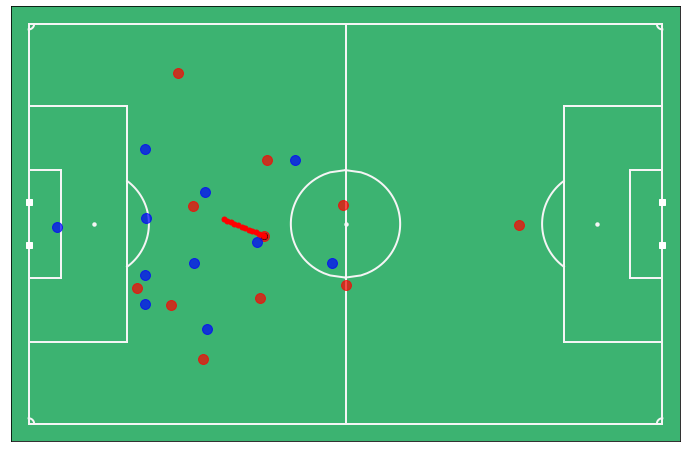

In [21]:
# Visualise and generate movie of pass indexed 1722
calculate_displacement_to_distance_ratio(home_passes, 1722, tracking_home, plot=True, makeMovie=True)

In [22]:
# Few trajectory plots were not as desired. This can be probably due to
# missing z-axis data (aerial balls) or inconsistency and NA values in ball tracking data.

#### 5.3 Opponents Distance

 Finding gaps and spaces between opponent’s is key to switch plays, penetrate defences and counter attacks. Creative passes which find spaces between opponents are risky to execute but can create a great attacking opportunity


 <br><br>
 Calculation
- Draw the line of pass from passer to the receiver
- Drop a normal to this line from the position of opponents
- Calculate distance of opponents from this line
- Alternatively, calculate estimated time taken by opponents to block line of pass
- Use a normal distance / time to reach threshold to filter opponents nearby

In [23]:
# Method to find point of intersection (x4, y4) from point (x3, y3) to the line joining (x1, y1) and (x2, y2)

def get_point_of_intersection_of_normal(x1, y1, x2, y2, x3, y3):
    k = ((y2-y1) * (x3-x1) - (x2-x1) * (y3-y1)) / ((y2-y1)**2 + (x2-x1)**2)

    # x4, y4 is the point of intersection
    x4 = x3 - k * (y2-y1)
    y4 = y3 + k * (x2-x1)

    return x4, y4
    

In [24]:
# Method to iterate through every opponent and determine how many opponents are likely to intercept the pass
# Input- team_passes: passes dataframe of team in possession, tracking_opponent: tracking dataframe of opponent team (not in possession)
# Input- start_frame: starting frame of pass, distance_threshold: distance in meteres (how far an average player is likely to intercept the pass), plot: Option to plot
# TODO: Introduce time to reach / intercept in place of distance

def find_intercepting_players(team_passes, tracking_opponent, start_frame, distance_threshold = 3, plot=False):
    count = 0
    
    x1, y1, x2, y2 = get_pass_start_end_coordinates(team_passes, start_frame)

    # X and Y position of column names in tracking data
    x_columns = [c for c in tracking_opponent.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
    y_columns = [c for c in tracking_opponent.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions

    if plot:
        fig, ax = plot_at_pass_frame(start_frame)
        ax.axline((x1, y1), (x2, y2), color='blue')

    # Loop every opponent player
    for i in range(0, 12):
        distance = None

        x3 = tracking_opponent.loc[start_frame][x_columns[i]]
        y3 = tracking_opponent.loc[start_frame][y_columns[i]]
        
        x4, y4 = get_point_of_intersection_of_normal(x1, y1, x2, y2, x3, y3)
        
        # If point of intersection lies on pass line segment, calculate distance of player along normal
        # (Case when nearby players may intercept the pass) -> Else calculate direct distance of players
        if min(x1, x2) <= x4 <= max(x1, x2) and min(y1, y2) <= y4 <= max(y1, y2):
            distance = calculate_distance(x4, y4, x3, y3)
        else:
            distance = calculate_distance(x3, y3, x1, y1)

        if distance <= distance_threshold:
            count = count + 1

            if plot:
                ax.axline((x3, y3), (x4, y4), color='red')

    return count

In [25]:
opponents_beaten = []
opponents_beaten_index = []

for index, passes in home_passes.iterrows():
    
    start_frame = home_passes.loc[index]['Start Frame']
    count = find_intercepting_players(home_passes, tracking_away, start_frame, distance_threshold = 3)
    
    opponents_beaten.append(count)
    opponents_beaten_index.append(index)

In [26]:
id = zip (opponents_beaten, opponents_beaten_index)

# View the passes that beat the most opponents
sorted(id, key=lambda x: x[0])[-9:]

[(2, 999),
 (2, 1197),
 (2, 1376),
 (2, 1564),
 (3, 71),
 (3, 197),
 (3, 737),
 (5, 193),
 (6, 430)]

##### 5.3.1 Plot and generate movie of pass indexed 430

Generating movie...done


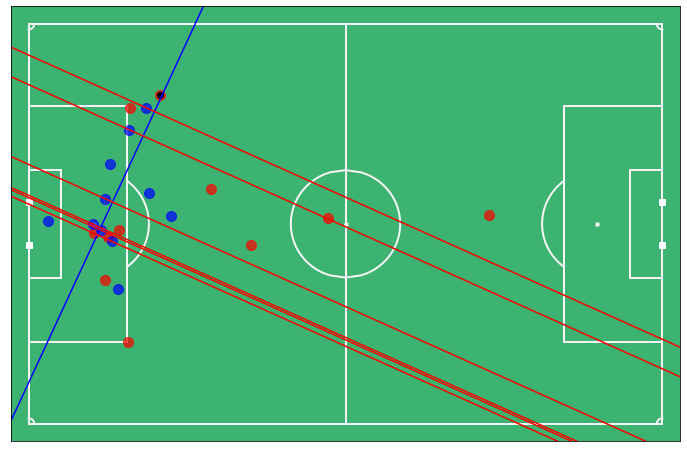

In [27]:
start_frame = home_passes.loc[430]['Start Frame']

find_intercepting_players(home_passes, tracking_away, start_frame, 3, plot=True)

# We see in the plot that pass 430 was able to beat 6 opponents
make_movie_of_pass(tracking_home, home_passes, tracking_away, home_passes.loc[430]['Start Frame'], 'pass 430-6')

#### 5.4 Pass under press

Players good with the ball, attract opponents when in possession
Inviting press:
- breaks defensive structures
- frees up other players on the field
- create chances of getting fouled
    - booking opponents
    - winning set pieces (freekick, penalty and corners)

<br><br>
Calculation
- Position of all 22 players are available at 24 frames/sec 
- Instantaneous velocity of each player can be calculated using ds/dt ( here, dt = 24/60 sec )
- Calculate D = distance of all opponents from the player making the pass (P)
- Calculate T<sub>i</sub> = time needed for each opponent to reach P = ( D / V<sub>i</sub> )<br>where V<sub>i</sub> is the velocity component of opponenti towards P
- Estimate the pressure on the player P using T<sub>i</sub> of the pressing opponents

In [28]:
# Determine opponent pressing by calculating the number of players pressing and the
# time needed for each player to reach the player getting pressed

# Input- frame: frame value of interest
# Input- passes_df: passes data frame of team with ball (in possession)
# Input- opponent_tracking: Tracking data of team without the ball
# Input- time_threshold: Threshold value within which opponent is expected to be called a pressing player (default: 2sec)

def calculate_opponents_press_info(frame, passes_df, opponent_tracking, time_threshold=2):
    x, y, _, _ = get_pass_start_end_coordinates(passes_df, frame)

    # column headers for player positions
    x_columns = [c for c in opponent_tracking.keys() if c[-2:].lower()=='_x' and c!='ball_x'] 
    y_columns = [c for c in opponent_tracking.keys() if c[-2:].lower()=='_y' and c!='ball_y']

    # column headers for player velocities
    vx_columns = [c for c in opponent_tracking.keys() if c[-3:].lower()=='_vx']
    vy_columns = [c for c in opponent_tracking.keys() if c[-3:].lower()=='_vy']

    frame_of_interest = opponent_tracking.loc[frame]
    
    pressing_players = []

    # Iterate through all 11 opponent players
    for i in range(0, 12):
        x1 = tracking_away.loc[frame][x_columns[i]]
        y1 = tracking_away.loc[frame][y_columns[i]]

        # Calculate distance between opponent (presser) and passer
        dist = calculate_distance(x, y, x1, y1)
        
        # Displacement vector from presser towards passer
        displacement_vector = [x1 - x, y1 - y]

        # Calculate magnitude of velocity of presser along displacement_vector
        velocity_projection_magnitude = (((x1 - x)*(tracking_away.loc[frame][vx_columns[i]])) + ((y1 - y)*(tracking_away.loc[frame][vy_columns[i]]))) / dist
        
        if velocity_projection_magnitude == 0:
            # avg acceleration assumed = 2 m/s^2
            time = np.sqrt(dist)
        else:
            # Estimated time to reach the passer
            time = dist / velocity_projection_magnitude
        
        # If time is negative, the presser needs to change direction, avg acceleration assumed = 2 m/s^2
        # We also assume initial velocity as 0 instead of negative for sake of easier calculation
        if  time < 0:
            time = np.sqrt(dist)

        # Players who can reach passer within time_threshold (default: 2sec)
        if time <= time_threshold:
            pressing_players.append(time)
    
    # Returned value: Pressing players who can reach passer within time_threshold (default: 2sec)
    return pressing_players

In [29]:
# Iterate through all home passes
for index, _ in home_passes.iterrows():
    start_frame = home_passes.loc[index]['Start Frame']
    
    # Calculate info of pressing players for every pass
    pressing_players = calculate_opponents_press_info(start_frame, home_passes, tracking_away)

    # Also make movie of pass where number of pressing opponents are more than 2
    if len(pressing_players) > 2:
        filename = 'pass under press ' + str(index)
        make_movie_of_pass(tracking_home, home_passes, tracking_away, start_frame, filename, True)

Generating movie...done
Generating movie...done
Generating movie...done


In [30]:
# We estimated passes under press and created movie clips for the same

#### 5.5 Pass error leading to shot/goal

- Players are bound to lose possession at some point in the match
- Loss in possession can be due to high-reward pass, opponent press,   defensive mistake, careless pass, duels etc
- Hence while valuing passes it is necessary to consider and quantify passing errors that lead to loss in possession

Pass errors calculated here are meant to used when determing the overall performance of an individual player/team


<br><br>
Calculation: Ball loss leading to dangerous situations<br>
Find the ball possession transition state (Loss of possession)
- Start from frame of goal / shot / high EPV * PC value / high xG situation
- Find the most recent ‘BALL LOST’ event of opponent team before the above frame
- Above event is a transition state

##### 5.5.1 Ball lost events

In [16]:
# BALL LOST is an event type
home_events['Type'].value_counts()

PASS              543
CHALLENGE         160
RECOVERY          135
BALL LOST         120
SET PIECE          34
BALL OUT           27
SHOT               13
FAULT RECEIVED      9
CARD                3
Name: Type, dtype: int64

In [17]:
# Sub types of ball lost event
home_events[home_events.Type=='BALL LOST'].groupby(['Type', 'Subtype']).size()

Type       Subtype               
BALL LOST  CLEARANCE                  1
           CLEARANCE-INTERCEPTION     1
           CROSS-INTERCEPTION         7
           FORCED                     5
           GOAL KICK-INTERCEPTION     2
           HAND BALL                  1
           HEAD                       6
           HEAD-INTERCEPTION          9
           INTERCEPTION              58
           OFFSIDE                    1
           THEFT                     15
dtype: int64

##### 5.5.2 Ball lost events leading to goals

In [18]:
# Method to search last index/frame of ball lost event before given time_frame
# df: dataframe of ball loses
# frame: frame before which search needs to be made
def get_ball_lose_event_before_frame(df, frame):
    time_frames = df['Start Frame']
    
    ball_lose_frame = None
    index = None

    # TODO: Use sorted search
    for idx, time_frame in time_frames.items():
        if frame < time_frame:
            break
        ball_lose_frame = time_frame
        index = idx
    
    return index, ball_lose_frame

In [19]:
# Ball losing is a common activity and quite common for creative players but can be very risky
home_ball_lose = home_events[home_events.Type=='BALL LOST']

# Ball lost events leading to goals
for index, away_shot in away_shots.iterrows():
    start_frame_of_shot = away_shots.loc[index]['Start Frame']
    index, home_team_ball_lost_event_leading_to_away_team_shot_start_frame = get_ball_lose_event_before_frame(home_ball_lose, start_frame_of_shot)

    isGoal = '-GOAL' in away_shot['Subtype']

    if isGoal:
        # Save match clip (from ball lost to goal)
        mviz.save_match_clip(tracking_home.iloc[home_team_ball_lost_event_leading_to_away_team_shot_start_frame-10:start_frame_of_shot+30],tracking_away.iloc[home_team_ball_lost_event_leading_to_away_team_shot_start_frame-10:start_frame_of_shot+30],'.',fname="pass error at frame " + str(home_team_ball_lost_event_leading_to_away_team_shot_start_frame),include_player_velocities=False)

Generating movie...done
Generating movie...done


In [ ]:
# Pass errors are not perfect and can be in many other scenarios
# More work and ideas are needed for identifying and quantifying pass errors

"""
Idea: categorizing and quantifying pass errors
Analyse sequence of few passes before transition (ideas)
- Categorize bad pass scenario (press, defensive clearance, poor decision making, inaccurate pass)
- How dangerous was the loss in possession? 
- Assign values to the errors
"""

### 6. Valuing Passes

Implement existing metrics for measuring pass impact/value

- Pitch Control x EPV
- VAEP value

#### 6.1 Pitch Control x EPV

<b>Pitch control</b> at a given location is the probability that a player (or team) will gain control of the ball if it moves directly to that location.

The <b>Expected Possession Value</b> (EPV) is essentially an estimate of which team will score the next goal, given all the spatiotemporal information available at any given time. Let G ∈ {−1, 1}, where the values represent one or the other team scoring next, respectively;

EPV = P<sub>poss</sub> ( G | situation ) = P<sub>poss</sub> ( G | ball, team, opponents, match state)

We will see why Pitch Control x EPV is a good metric for valuing passes

In [21]:
# first get pitch control model parameters
params = mpc.default_model_params()

# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]

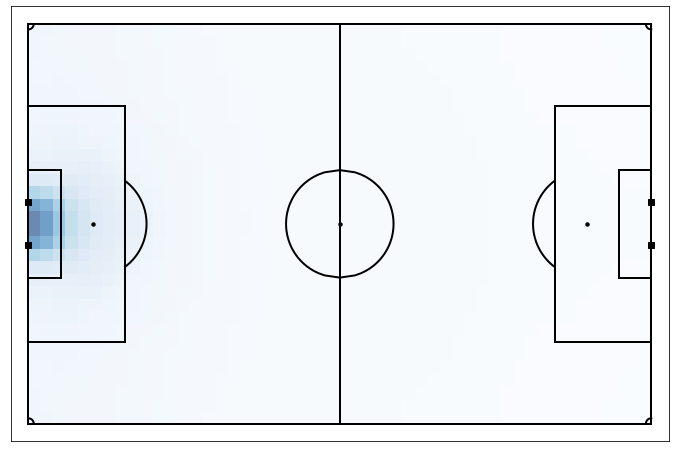

In [22]:
""" *** GET EPV SURFACE **** """
home_attack_direction = mio.find_playing_direction(tracking_home,'Home') # 1 if shooting left-right, else -1
EPV = mepv.load_EPV_grid(r"C:\Users\adnanazmat\Downloads\PROJECTS\LaurieOnTracking\EPV_grid.csv")

# plot the EPV surface
mviz.plot_EPV(EPV,field_dimen=(106.0,68),attack_direction=home_attack_direction)

In [23]:
# home team value added
home_pass_value_added = []
for i,pass_ in home_passes.iterrows():
    EEPV_added, EPV_diff = mepv.calculate_epv_added( i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
    home_pass_value_added.append( (i,EEPV_added,EPV_diff ) )

In [24]:
# away team value added
away_pass_value_added = []
for i,pass_ in away_passes.iterrows():
    EEPV_added, EPV_diff = mepv.calculate_epv_added( i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
    away_pass_value_added.append( (i,EEPV_added,EPV_diff ) )

In [25]:
home_pass_value_added = sorted(home_pass_value_added, key = lambda x: x[1], reverse=True)  
away_pass_value_added = sorted(away_pass_value_added, key = lambda x: x[1], reverse=True)

In [26]:
print("Top 5 home team passes by expected EPV-added")
print(home_pass_value_added[:5])
print("Top 5 away team passes by expected EPV-added")
print(away_pass_value_added[:5])

Top 5 home team passes by expected EPV-added
[(1753, 0.09134393894242654, 0.2252), (1478, 0.0725662469979875, 0.36379999999999996), (197, 0.061713985330662274, 0.2444), (430, 0.04848923317187011, 0.10749999999999998), (851, 0.04528996595787534, 0.1001)]
Top 5 away team passes by expected EPV-added
[(1663, 0.07350679988214434, 0.0378), (961, 0.07103134497967961, 0.1555), (1901, 0.06363375695912961, 0.2474), (822, 0.0527647290646007, 0.0664), (1735, 0.0318116338246547, -0.005600000000000001)]


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

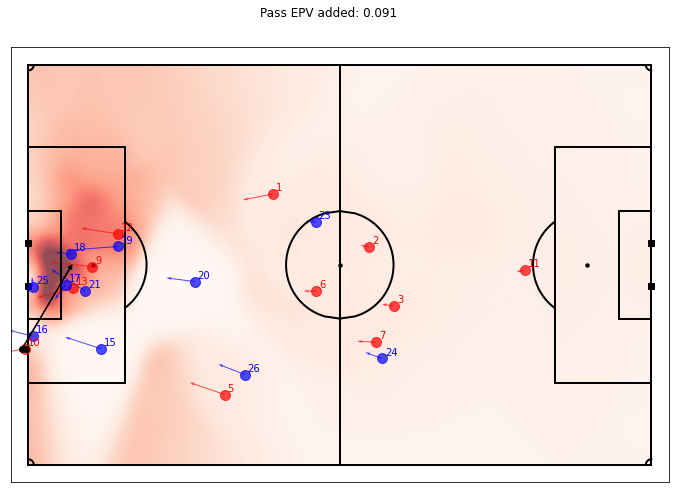

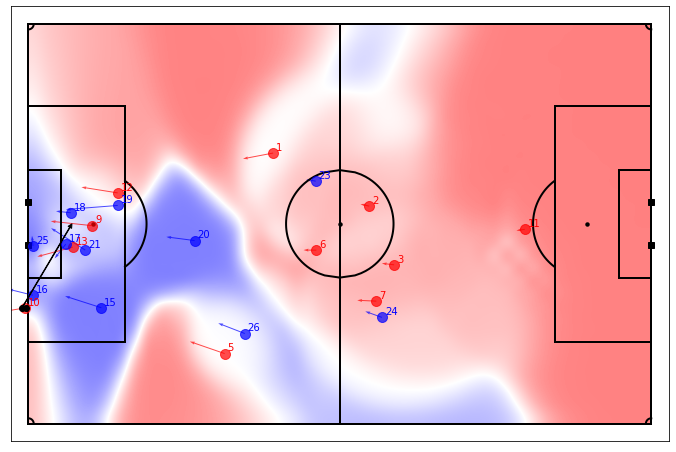

In [27]:
event_number = 1753 # home team assist to header off target
EEPV_added, EPV_diff = mepv.calculate_epv_added( event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50, offsides=True)
fig,ax = mviz.plot_EPV_for_event( event_number, events,  tracking_home, tracking_away, PPCF, EPV, annotate=True )
fig.suptitle('Pass EPV added: %1.3f' % EEPV_added, y=0.95 )

mviz.plot_pitchcontrol_for_event( event_number, events,  tracking_home, tracking_away, PPCF, annotate=True )

#### 6.2 TODO: VAEP metric
- See: [Actions Speak Louder than Goals: Valuing Player Actions in Soccer](https://arxiv.org/pdf/1802.07127.pdf)
- Implementation: https://github.com/ML-KULeuven/socceraction

Note: VAEP model only uses event data

In [ ]:
# Calculable Scenarios

# Distance of opponents along line of pass (opponent's beaten) -> Done
# Opponents within 'x' distance along line of pass (opponents beaten) -> Done
# UCL broadcast data -> Abandoned (Event Data not available cannot be used)
# Wrong pass that led to goal/opportunity -> Find a way to identify scenarios where pass errors were made that led to dangerous situations -> Done
# Velocity and number of pressing opponents -> Done
# Pass EPV added -> Done


# TODO: Future work
# Disguising intention of pass
# Vertical and diagonal passes (blog images) (space behind defenders)
# VAEP (Scisports)